In [1]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyarrow import feather
from sklearn.linear_model import LogisticRegression
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import ptitprince as pt
import seaborn as sns
from scipy.stats import pearsonr 
from scipy.stats import ttest_1samp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['axes.grid'] = True

In [2]:
os.chdir('../')

from helpers import dot2_

In [3]:
os.getcwd()

'C:\\Users\\Bio_Psych\\Desktop\\Deniz\\tf-cpu\\p1_generalization'

In [4]:
# CONFIG

PATH_RNN_DATA ='data/rnn_raw_data/'
RNN_FILE_NAME = 'lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'

# RNN_FILE_NAME ="lstm2_rei_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}"

# number of RNN instances
N_IDS = 20
# number of random walk instances
N_WALKS = 3
# number of trials per episode
N_TRIALS = 300
# number of actions/bandits
N_ACTIONS = 4

In [5]:
# function to calculate scatter index as in Ebitz et al. 2018
def get_scatter_index(point, within_cluster, between_cluster):
    # distance within
    d_within = np.sum(np.linalg.norm(point-within_cluster, axis = 1))
    # distance between
    d_between = np.sum(np.linalg.norm(point-between_cluster, axis = 1))
    # scatter index
    scatter_index = d_within/d_between
    return(scatter_index)

In [6]:
rnn_file_path = PATH_RNN_DATA + RNN_FILE_NAME

# container for choice axis for all RNN instances 
choice_axis = np.zeros([N_IDS*N_WALKS,N_TRIALS, N_ACTIONS])
# container for choice axis (probability scale) for all RNN instances 
choice_axis_proba = np.zeros([N_IDS*N_WALKS,N_TRIALS, N_ACTIONS])
# container for switch axis for all RNN instances 
switch_axis = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for switch axis (probability scale) for all RNN instances 
switch_axis_proba = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for value axis for all RNN instances 
value_axis = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect previous reward
prev_rew = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect switch trials
is_switch = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect value output
values = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect scatter index 
scatter_index = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect choice predictions
choice_preds = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect noise added to hidden units
weber_noise = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for switch choice axis for all RNN instances 
switch_choice_axis = np.zeros([N_IDS*N_WALKS,N_TRIALS, N_ACTIONS])
# container for switch choice axis (probability scale) for all RNN instances
switch_choice_axis_proba = np.zeros([N_IDS*N_WALKS,N_TRIALS, N_ACTIONS])

for walk in range(1, N_WALKS+1):
    for id_ in range(N_IDS):

        # get data from RNN instance
        d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
        df = d.reset_index()
        # get choices
        choices = df.choice.to_numpy()
        # extract hidden unit activity
        hidden_units = df.loc[:, [col.startswith('rnn_state') for col in df.columns.values]]
        # extract weber noise
        noise = df.loc[:, [col.startswith('added_noise_rnn_state') for col in df.columns.values]]
        # collect norm of weber noise
        weber_noise[(walk-1)*N_IDS+id_] = np.linalg.norm(noise.to_numpy(), axis = 1)
#         # hidden units with noise
#         hidden_units = hidden_units.to_numpy() + noise.to_numpy()
        # onehot encoding for choices
        oh_choices = pd.get_dummies(df.choice).to_numpy()
        
        # prepare empty vector for choice predictions
        tmp_choice_vec = np.zeros(N_TRIALS)
        
        # init pca object
        pca = PCA()
        # standardize hidden unit activity
        st_hidden = StandardScaler().fit_transform(hidden_units)  
        # predictor X is principal components
        X = pca.fit_transform(st_hidden)
        
        #########################
        # choice axis 
        #########################
                
        for a in range(N_ACTIONS):

            # get choice axis: binary logistic regression for each action
            y = oh_choices[:,a]
            clf = LogisticRegression(random_state=0, fit_intercept=True).fit(X, y)
            # save linear combination as axis
            choice_axis[(walk-1)*N_IDS+id_,:,a] = np.dot(X,np.transpose(clf.coef_)).flatten() + clf.intercept_
            # save probability
            choice_axis_proba[(walk-1)*N_IDS+id_,:,a] = clf.predict_proba(X)[:,1]
            # save choice predictions for action a
            clf = LogisticRegression(random_state=0, fit_intercept=True).fit(X, y)
            tmp_choice_vec[choices==a] = clf.predict(X)[choices==a]

        #########################
        # choice predictions 
        #########################
        
        # save choice predictions for all actions
        choice_preds[(walk-1)*N_IDS+id_,:] = tmp_choice_vec
                
        #####################
        # switch choice axis 
        #####################
        # axis shows log probs of switching to a choice i
        
        # create switch predictor with dim (N_Trials, N_ACTIONS) by repeating is_switch N_ACTION times
        oh_switches = np.transpose(np.reshape(np.tile(df.is_switch.values, N_ACTIONS), (N_ACTIONS, N_TRIALS)))
        # elementwise multiplication (interaction term)
        oh_switch_choices = np.multiply(oh_choices, oh_switches)
        
        for a in range(N_ACTIONS):

            # get choice axis: binary logistic regression for each action
            y = oh_switch_choices[:,a]
            clf = LogisticRegression(random_state=0, fit_intercept=True).fit(X, y)
            # save linear combination as axis
            switch_choice_axis[(walk-1)*N_IDS+id_,:,a] = np.dot(X,np.transpose(clf.coef_)).flatten() + clf.intercept_
            # save probability
            switch_choice_axis_proba[(walk-1)*N_IDS+id_,:,a] = clf.predict_proba(X)[:,1]
            # save choice predictions for action a
            clf = LogisticRegression(random_state=0, fit_intercept=True).fit(X, y)
        
        #########################
        # scatter indesx 
        #########################
            
        # save scatter index
        ch_axis_plane = choice_axis[(walk-1)*N_IDS+id_]
        scatter_index[(walk-1)*N_IDS+id_,:] = [get_scatter_index(point = ch_axis_plane[t, :],
                                                               within_cluster = ch_axis_plane[df.choice.to_numpy() == df.choice.to_numpy()[t],:],
                                                               between_cluster = ch_axis_plane[df.choice.to_numpy() != df.choice.to_numpy()[t],:]) for t in range(N_TRIALS)]
            
                
        #########################
        # switch axis 
        #########################
        
        # get switch axis: binary logistic regression for switches
        #X = hidden_units
        y = df.is_switch
        clf = LogisticRegression(random_state=0, fit_intercept=True).fit(X, y)
        # get linear combination as axis
        switch_axis[(walk-1)*N_IDS+id_, :] = np.dot(X,np.transpose(clf.coef_)).flatten() + clf.intercept_
        # save probability
        switch_axis_proba[(walk-1)*N_IDS+id_, :] = clf.predict_proba(X)[:,1]
                    
        #########################
        # value axis 
        #########################
    
        # get value axis: linear regression for values
        #X = hidden_units
        y = df.value
        lr = LinearRegression().fit(X, y)
        # get linear combination as axis
        value_axis[(walk-1)*N_IDS+id_, :] = np.dot(X,np.transpose(lr.coef_)).flatten() + lr.intercept_
        
                
        #########################
        # variable collection 
        #########################
        
        # get previous reward
        prev_rew[(walk-1)*N_IDS+id_, :] = pd.Series(df.reward).shift(1).to_numpy()
        
        # get switch trials 
        is_switch[(walk-1)*N_IDS+id_, :] = df.is_switch.to_numpy()
        
        # get values
        values[(walk-1)*N_IDS+id_, :] = df.value.to_numpy()
        

In [37]:
np.shape(X[:,:4])

(300, 4)


# Predictive Accuracy of Switch and Stay


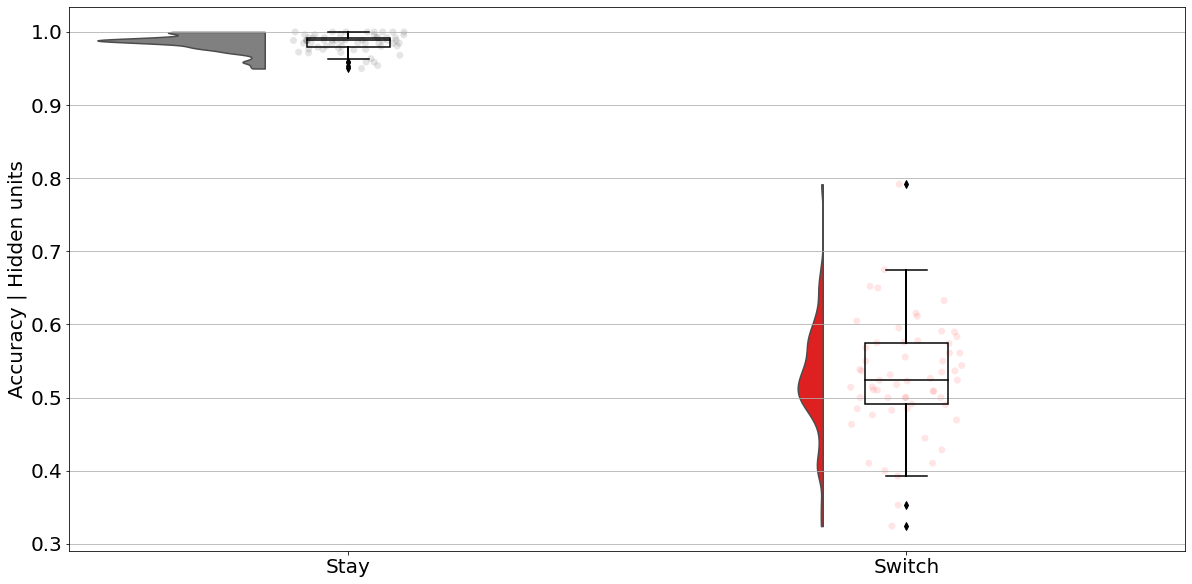

In [50]:
# plot accuracy for stay and switch

ids = list(np.repeat(np.linspace(0,N_IDS-1, N_IDS),N_TRIALS))*N_WALKS
walks = list(np.repeat(np.linspace(0,N_WALKS-1, N_WALKS), N_TRIALS*N_IDS))
df = pd.DataFrame({'id': ids,
                   'walk': walks,
              'preds': choice_preds.flatten(),
              'is_switch': is_switch.flatten()})

stay_switch_accuracy = df.groupby(['id', 'walk','is_switch']).mean()
df = stay_switch_accuracy.reset_index()

switch_accuracy = df[df['is_switch']==1]['preds'].to_numpy()
stay_accuracy = df[df['is_switch']==0]['preds'].to_numpy()

# plotting
plot_df = pd.DataFrame({"accuracy": list(stay_accuracy) + list(switch_accuracy),
                       "type": ['Stay'] * len(stay_accuracy)  + ['Switch'] * len(switch_accuracy)})

# plotting the clouds
f, ax = plt.subplots()
dy="accuracy"; dx="type"; ort="v"; pal = {"Stay": "grey", "Switch": "red"}#sns.color_palette(n_colors=2)
ax=pt.half_violinplot( x = dx, y = dy, data = plot_df, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)


pal1 = {"Stay": "black", "Switch": "red"}
ax=sns.stripplot( x = dx, y = dy, data = plot_df, palette = pal1, edgecolor = "white",
size = 7, jitter = 1, zorder = 0, orient = ort, alpha = 0.1)

x=sns.boxplot( x = dx, y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)

plt.ylabel('Accuracy | Hidden units')
plt.xlabel('')

plt.savefig('../p1_generalization/plots/hidden_unit_stay_switch_prediction_plot.png', dpi = 600)

In [12]:
# write csv for JAGS
df = pd.DataFrame({'switch_accuracy': switch_accuracy})
df.to_csv('switch_accr')

# Exploration of the model

In [187]:
id_ = 3
walk = 3


# get data from RNN instance
d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
df = d.reset_index()

# get switch choices
is_switch = df.is_switch.values==1
#choice = df.choice.values

# get pers rank
# get running average


num_neg = np.array([0,0,0,0])
one_hot = pd.get_dummies(df['choice'])
one_hot_rewards = np.transpose(np.multiply(np.transpose(one_hot.values),df.reward.values))
pers_rank = np.array([0,0,0,0])


for t in range(300):
    
    if is_switch[t]:
        print("Switch Choice is: {}".format(choice[t]))
        print("Pers Rank is {}".format(pers_rank))
        print("running average is {}".format(np.nan_to_num(np.sum(one_hot_rewards[:t,:], axis = 0)/pers_rank)))
        print("number of negatives is {}".format(num_neg))
        print("########NEW TRIAL ######### \n")

    pers_rank = np.array([0,0,0,0])
    ch, ra = np.unique(choice[:t+1], return_counts=True)
    pers_rank[ch] = ra
    num_neg[choice[t]] = num_neg[choice[t]] + int(0>df.reward.values[t])
    



Switch Choice is: 1
Pers Rank is [0 0 0 1]
running average is [ 0.          0.          0.         -0.25339734]
number of negatives is [0 0 0 1]
########NEW TRIAL ######### 

Switch Choice is: 0
Pers Rank is [0 1 0 1]
running average is [ 0.          0.24655992  0.         -0.25339734]
number of negatives is [0 0 0 1]
########NEW TRIAL ######### 

Switch Choice is: 1
Pers Rank is [1 1 0 1]
running average is [-0.14164774  0.24655992  0.         -0.25339734]
number of negatives is [1 0 0 1]
########NEW TRIAL ######### 

Switch Choice is: 0
Pers Rank is [ 1 13  0  1]
running average is [-0.14164774  0.18393298  0.         -0.25339734]
number of negatives is [1 0 0 1]
########NEW TRIAL ######### 

Switch Choice is: 1
Pers Rank is [ 2 13  0  1]
running average is [-0.06160214  0.18393298  0.         -0.25339734]
number of negatives is [1 0 0 1]
########NEW TRIAL ######### 

Switch Choice is: 2
Pers Rank is [ 2 22  0  1]
running average is [-0.06160214  0.13351778  0.         -0.25339734]
n

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [185]:
num_neg = np.array([0,0,0,0])
one_hot = pd.get_dummies(df['choice'])
one_hot_rewards = np.transpose(np.multiply(np.transpose(one_hot.values),df.reward.values))
pers_rank = np.array([0,0,0,0])


for t in range(300):
    
    #if is_switch[t]:
    #print("Switch Choice is: {}".format(choice[t]))
    print("Pers Rank is {}".format(pers_rank))
    print("running average is {}".format(np.nan_to_num(np.sum(one_hot_rewards[:t,:], axis = 0)/pers_rank)))
    #print("number of negatives is {}".format(num_neg))
    print("########NEW TRIAL ######### \n")

    print(one_hot_rewards[:t+1,:])

    pers_rank = np.array([0,0,0,0])
    ch, ra = np.unique(choice[:t+1], return_counts=True)
    pers_rank[ch] = ra
    num_neg[choice[t]] = num_neg[choice[t]] + 0>df.reward.values[t]

Pers Rank is [0 0 0 0]
running average is [0. 0. 0. 0.]
########NEW TRIAL ######### 

[[-0.         -0.         -0.         -0.25339734]]
Pers Rank is [0 0 0 1]
running average is [ 0.          0.          0.         -0.25339734]
########NEW TRIAL ######### 

[[-0.         -0.         -0.         -0.25339734]
 [ 0.          0.24655992  0.          0.        ]]
Pers Rank is [0 1 0 1]
running average is [ 0.          0.24655992  0.         -0.25339734]
########NEW TRIAL ######### 

[[-0.         -0.         -0.         -0.25339734]
 [ 0.          0.24655992  0.          0.        ]
 [-0.14164774 -0.         -0.         -0.        ]]
Pers Rank is [1 1 0 1]
running average is [-0.14164774  0.24655992  0.         -0.25339734]
########NEW TRIAL ######### 

[[-0.         -0.         -0.         -0.25339734]
 [ 0.          0.24655992  0.          0.        ]
 [-0.14164774 -0.         -0.         -0.        ]
 [ 0.          0.2072473   0.          0.        ]]
Pers Rank is [1 2 0 1]
running ave

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


[[-0.         -0.         -0.         -0.25339734]
 [ 0.          0.24655992  0.          0.        ]
 [-0.14164774 -0.         -0.         -0.        ]
 [ 0.          0.2072473   0.          0.        ]
 [ 0.          0.18157954  0.          0.        ]
 [ 0.          0.19806445  0.          0.        ]
 [ 0.          0.23814755  0.          0.        ]
 [ 0.          0.17190607  0.          0.        ]
 [ 0.          0.22998384  0.          0.        ]
 [ 0.          0.24025312  0.          0.        ]
 [ 0.          0.19092327  0.          0.        ]
 [ 0.          0.0976986   0.          0.        ]
 [ 0.          0.12219981  0.          0.        ]
 [ 0.          0.11141873  0.          0.        ]
 [ 0.          0.15514658  0.          0.        ]
 [ 0.01844347  0.          0.          0.        ]
 [ 0.          0.16610743  0.          0.        ]
 [ 0.          0.1453371   0.          0.        ]
 [ 0.          0.06198902  0.          0.        ]
 [-0.         -0.04161207 -0.  

Pers Rank is [44 84 15 27]
running average is [ 0.06121772  0.13298716 -0.00965487 -0.04807516]
########NEW TRIAL ######### 

[[-0.         -0.         -0.         -0.25339734]
 [ 0.          0.24655992  0.          0.        ]
 [-0.14164774 -0.         -0.         -0.        ]
 [ 0.          0.2072473   0.          0.        ]
 [ 0.          0.18157954  0.          0.        ]
 [ 0.          0.19806445  0.          0.        ]
 [ 0.          0.23814755  0.          0.        ]
 [ 0.          0.17190607  0.          0.        ]
 [ 0.          0.22998384  0.          0.        ]
 [ 0.          0.24025312  0.          0.        ]
 [ 0.          0.19092327  0.          0.        ]
 [ 0.          0.0976986   0.          0.        ]
 [ 0.          0.12219981  0.          0.        ]
 [ 0.          0.11141873  0.          0.        ]
 [ 0.          0.15514658  0.          0.        ]
 [ 0.01844347  0.          0.          0.        ]
 [ 0.          0.16610743  0.          0.        ]
 [ 0.  

[[-0.         -0.         -0.         -0.25339734]
 [ 0.          0.24655992  0.          0.        ]
 [-0.14164774 -0.         -0.         -0.        ]
 [ 0.          0.2072473   0.          0.        ]
 [ 0.          0.18157954  0.          0.        ]
 [ 0.          0.19806445  0.          0.        ]
 [ 0.          0.23814755  0.          0.        ]
 [ 0.          0.17190607  0.          0.        ]
 [ 0.          0.22998384  0.          0.        ]
 [ 0.          0.24025312  0.          0.        ]
 [ 0.          0.19092327  0.          0.        ]
 [ 0.          0.0976986   0.          0.        ]
 [ 0.          0.12219981  0.          0.        ]
 [ 0.          0.11141873  0.          0.        ]
 [ 0.          0.15514658  0.          0.        ]
 [ 0.01844347  0.          0.          0.        ]
 [ 0.          0.16610743  0.          0.        ]
 [ 0.          0.1453371   0.          0.        ]
 [ 0.          0.06198902  0.          0.        ]
 [-0.         -0.04161207 -0.  

 [ 0.          0.          0.          0.3026022 ]]
Pers Rank is [ 44 143  15  43]
running average is [ 0.06121772  0.19143757 -0.00965487  0.06872896]
########NEW TRIAL ######### 

[[-0.         -0.         -0.         -0.25339734]
 [ 0.          0.24655992  0.          0.        ]
 [-0.14164774 -0.         -0.         -0.        ]
 [ 0.          0.2072473   0.          0.        ]
 [ 0.          0.18157954  0.          0.        ]
 [ 0.          0.19806445  0.          0.        ]
 [ 0.          0.23814755  0.          0.        ]
 [ 0.          0.17190607  0.          0.        ]
 [ 0.          0.22998384  0.          0.        ]
 [ 0.          0.24025312  0.          0.        ]
 [ 0.          0.19092327  0.          0.        ]
 [ 0.          0.0976986   0.          0.        ]
 [ 0.          0.12219981  0.          0.        ]
 [ 0.          0.11141873  0.          0.        ]
 [ 0.          0.15514658  0.          0.        ]
 [ 0.01844347  0.          0.          0.        ]
 [

[0 0 0 1]
[ 0.          0.          0.         -0.25339734]
[0 0 0 1]
[0 1 0 1]
[ 0.          0.24655992  0.         -0.25339734]
[0 0 0 1]
[1 1 0 1]
[-0.14164774  0.24655992  0.         -0.25339734]
[1 0 0 1]
[1 2 0 1]
[-0.14164774  0.22690361  0.         -0.25339734]
[1 0 0 1]
[1 3 0 1]
[-0.14164774  0.21179558  0.         -0.25339734]
[1 0 0 1]
[1 4 0 1]
[-0.14164774  0.2083628   0.         -0.25339734]
[1 0 0 1]
[1 5 0 1]
[-0.14164774  0.21431975  0.         -0.25339734]
[1 0 0 1]
[1 6 0 1]
[-0.14164774  0.2072508   0.         -0.25339734]
[1 0 0 1]
[1 7 0 1]
[-0.14164774  0.21049838  0.         -0.25339734]
[1 0 0 1]
[1 8 0 1]
[-0.14164774  0.21421772  0.         -0.25339734]
[1 0 0 1]
[1 9 0 1]
[-0.14164774  0.21162945  0.         -0.25339734]
[1 0 0 1]
[ 1 10  0  1]
[-0.14164774  0.20023637  0.         -0.25339734]
[1 0 0 1]
[ 1 11  0  1]
[-0.14164774  0.19314213  0.         -0.25339734]
[1 0 0 1]
[ 1 12  0  1]
[-0.14164774  0.18633185  0.         -0.25339734]
[1 0 0 1]
[ 1 13  

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [169]:
num_neg

array([1, 0, 0, 0])

array([-0.00228464,  0.00166595,  0.        , -0.00342429])

In [143]:
ra

array([ 62, 148,  16,  74], dtype=int64)

In [138]:
one_hot

,0,1,2,3
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
295,0,0,0,1
296,0,0,0,1
297,1,0,0,0
298,0,0,0,1


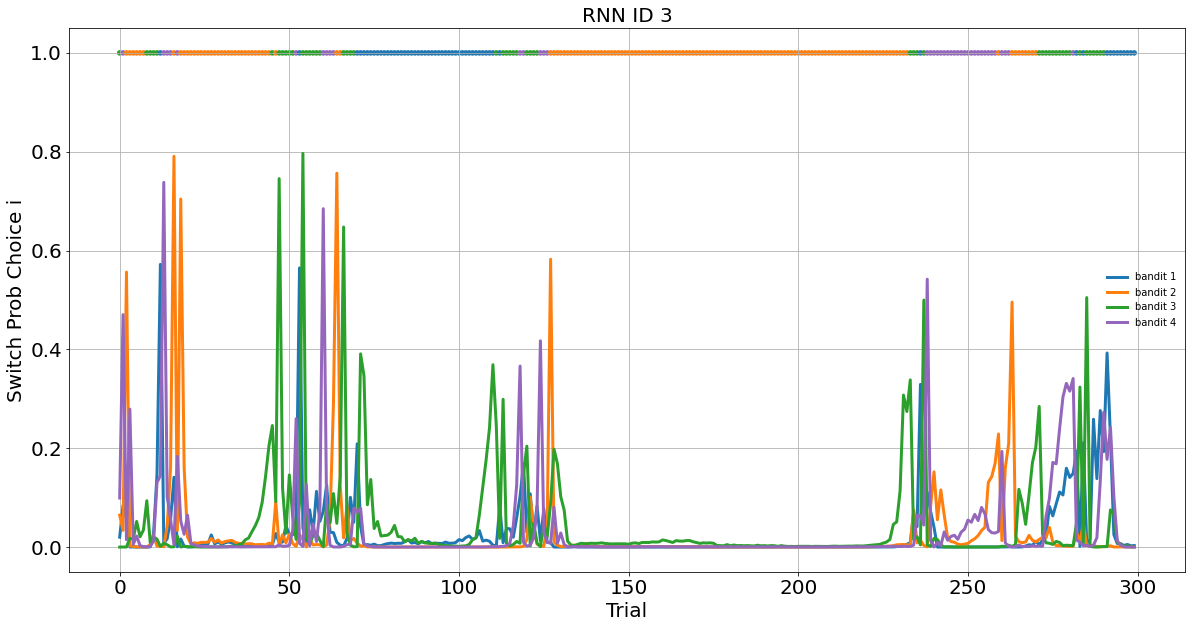

In [135]:
id_ = 3
walk = 3


# get data from RNN instance
d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
df = d.reset_index()

df = d.reset_index()
my_cols = ['tab:blue','tab:orange','tab:green','tab:purple']
title = 'RNN ID {}'.format(id_)

# get reward_probability
p_rews_cols = [word for word in df.columns if word.startswith('p_rew')] 
p_rews = df[p_rews_cols]

# prepare actions array
ch_cols = [word for word in df.columns if word.startswith('choice')] 
my_choices = df[ch_cols]
actions = [1]*df.shape[0]

# # get accuracy
# accuracy = [int(ch==np.argmax([p1,p2,p3,p4])) for ch, p1, p2, p3, p4 in zip(df['choice'], df['p_rew_1'], df['p_rew_2'], df['p_rew_3'], df['p_rew_4'])]
# accuracy = 'Accuracy  = {}'.format(str(round(np.mean(accuracy), 3)))

# get proportion of switches
# is_switch = [int(df['choice'].values[t] != df['choice'].values[t-1]) for t in range(1, len(df.choice))]
# prop_switches = np.round(np.sum(is_switch)/len(is_switch),2)
# prop_switches = 'Prop. Switches = {}'.format(prop_switches)

# get reward_probability
sm_cols = [word for word in df.columns if word.startswith('softmax')] 
sm = df[sm_cols]



# plot
# for i, col in enumerate(my_cols):
#     plt.plot(range(300), p_rews.iloc[:,i], color=col, linewidth = 2, alpha = 0.2)
    
# # plot
# for i, col in enumerate(my_cols):
#     plt.plot(range(300), sm.iloc[:,i], color=col, linewidth = 2, alpha = 1)
    
# for i, col in enumerate(my_cols):
#     plt.plot(range(300), choice_axis_proba[59,:,i], '--', color=col, linewidth = 2, alpha = 1)
    
# plt.plot(range(300), switch_axis_proba[59,:], color = 'red')

# plt.plot(range(300), prev_rew[59,:], color = 'black')

for i, col in enumerate(my_cols):
    plt.plot(range(300), switch_choice_axis_proba[(walk-1)*N_IDS+id_,:, i], color=col, linewidth = 3, alpha = 1)



# add legend
plt.legend(['bandit 1', 'bandit 2', 'bandit 3', 'bandit 4'], frameon = False, prop={'size': 10})

# create color for actions
tmp_col = []

for col in range(my_choices['choice'].shape[0]):
    tmp_col.append(my_cols[int(my_choices['choice'].iloc[col])])

plt.scatter(range(len(actions)), actions, c = tmp_col, s = 20)

# labels
plt.xlabel('Trial')
plt.ylabel('Switch Prob Choice i')

# main title
plt.title(title, size = 20)

#plt.savefig('../p1_generalization/plots/perf_plot_{}.png'.format(title), dpi = 600)

plt.show()

Text(0, 0.5, 'Switch Log odds Choice i')

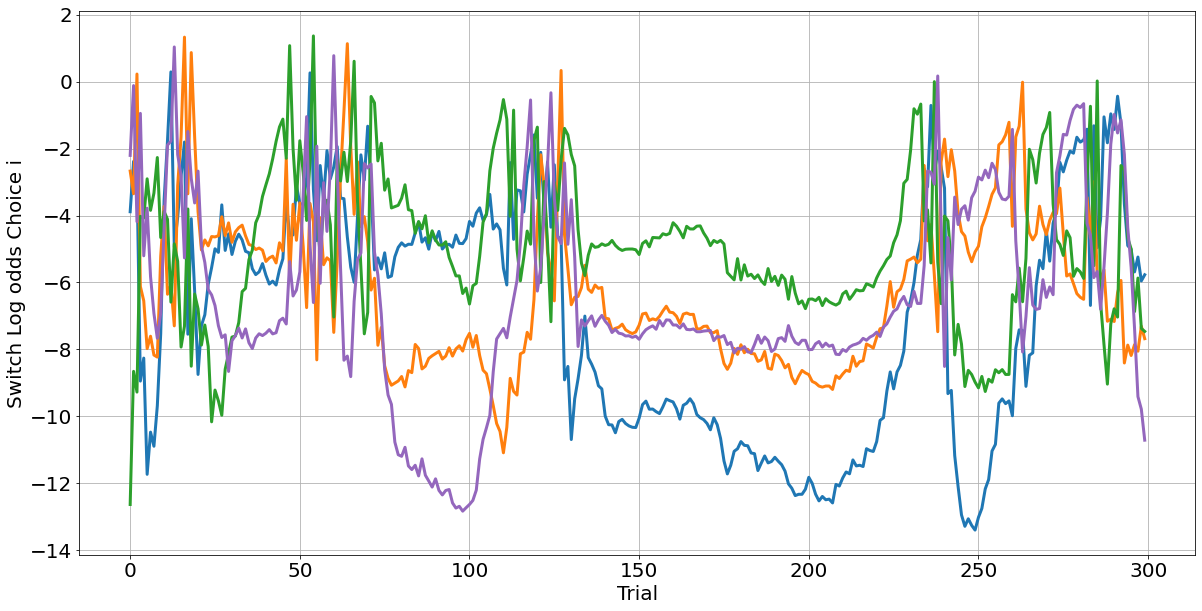

In [136]:
for i, col in enumerate(my_cols):
    plt.plot(range(300), switch_choice_axis[(walk-1)*N_IDS+id_,:, i], color=col, linewidth = 3, alpha = 1)
    
# labels
plt.xlabel('Trial')
plt.ylabel('Switch Log odds Choice i')

Text(0, 0.5, 'Previous Reward (Input in trial t)')

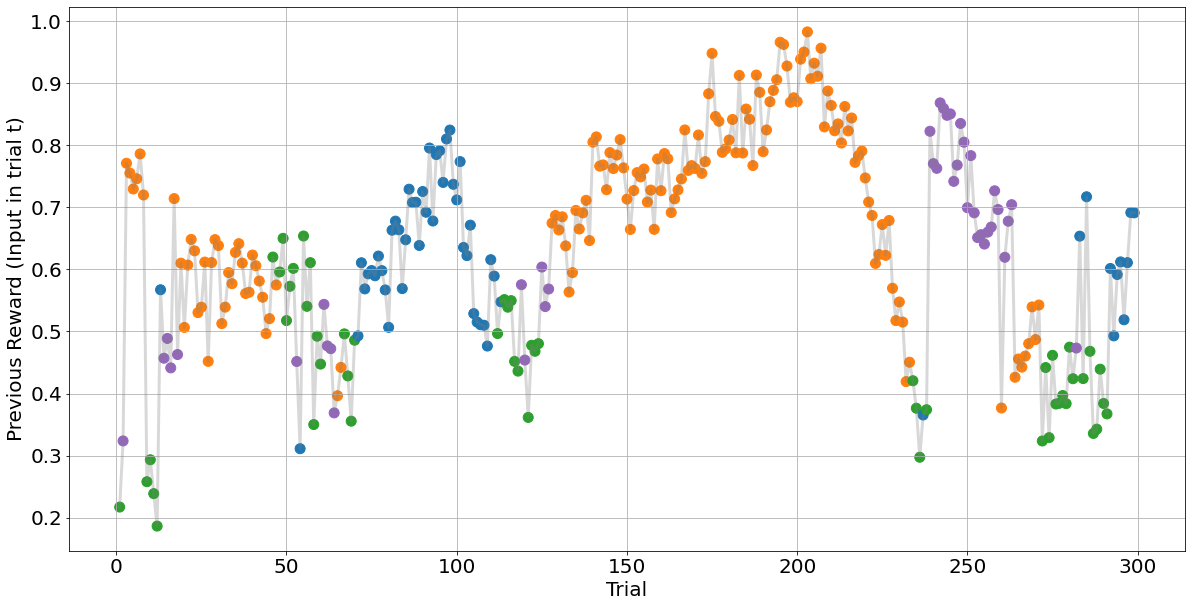

In [137]:
col_prev_action = pd.Series(tmp_col).shift(1).to_numpy()
col_prev_action[0] = 'grey'

plt.scatter(range(300), prev_rew[(walk-1)*N_IDS+id_,:],c = col_prev_action, s = 100)
plt.plot(prev_rew[(walk-1)*N_IDS+id_,:], c = 'grey', alpha = 0.3, linewidth = 3)

# labels
plt.xlabel('Trial')
plt.ylabel('Previous Reward (Input in trial t)')

In [52]:
df = pd.DataFrame(switch_choice_axis[59,:, :])
df.corr()

,0,1,2,3
0,1.000000,0.190895,0.407256,0.717116
1,0.190895,1.000000,0.217803,0.476381
2,0.407256,0.217803,1.000000,0.533073
3,0.717116,0.476381,0.533073,1.000000


# Correlation of TDR Axis with task variables

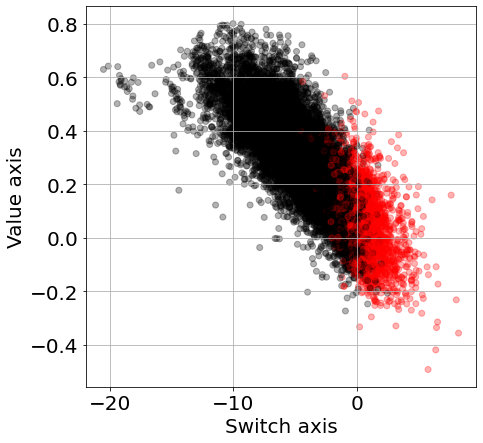

In [66]:
# create color for switches
my_sw_cols = ['black', 'red']
sw_col = [my_sw_cols[int(is_switch.flatten()[t])] for t in range(np.shape(is_switch.flatten())[0])]

plt.scatter(switch_axis, value_axis, c = sw_col, alpha = 0.3)
plt.xlabel('Switch axis')
plt.ylabel('Value axis')



plt.savefig('../p1_generalization/plots/scatter_switch_value.png', dpi = 600)

In [15]:
# statistics
r = pearsonr(switch_axis.flatten(), value_axis.flatten())
print(r)
print('Degress of Freedom')
print(len(switch_axis.flatten())-2)

(-0.8012088226942504, 0.0)
Degress of Freedom
17998


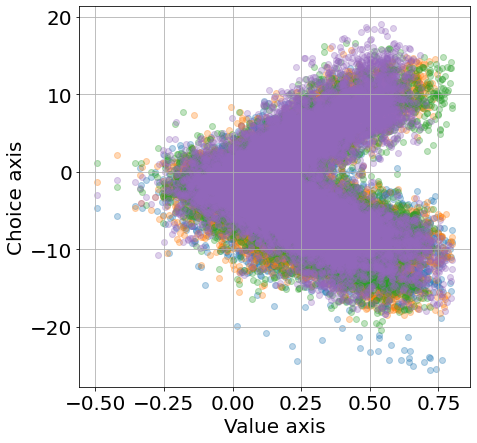

In [16]:
my_ch_cols = ['tab:blue','tab:orange','tab:green','tab:purple'] 

for a in range(N_ACTIONS):
    plt.scatter(value_axis, choice_axis[:,:,a], alpha = 0.3, c = my_ch_cols[a])
    
plt.xlabel('Value axis')
plt.ylabel('Choice axis')

plt.savefig('../p1_generalization/plots/scatter_value_choice.png', dpi = 600)

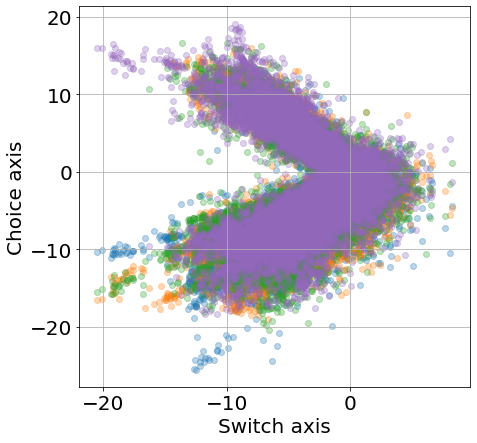

In [17]:
for a in range(N_ACTIONS):
    plt.scatter(switch_axis[:,:], choice_axis[:,:,a], alpha = 0.3, c = my_ch_cols[a])

plt.xlabel('Switch axis')
plt.ylabel('Choice axis')

plt.savefig('../p1_generalization/plots/scatter_switch_choice.png', dpi = 600)

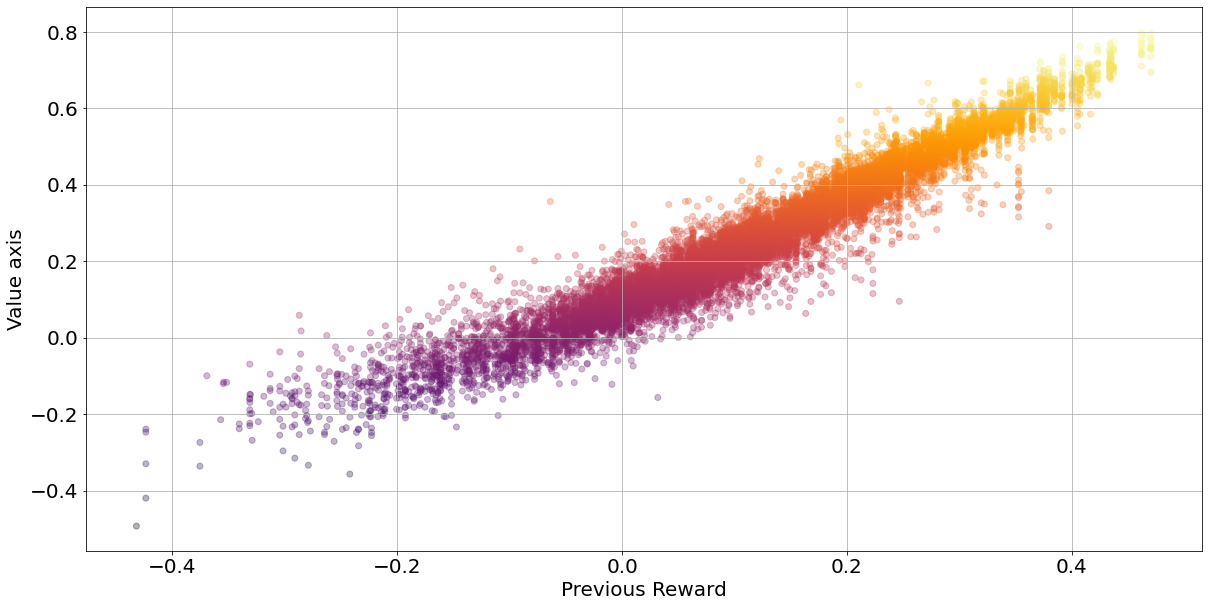

In [51]:
plt.scatter(prev_rew[:,1:], value_axis[:,1:], c = values[:,1:].flatten(), cmap = 'inferno', alpha = 0.3)
plt.xlabel('Previous Reward')
plt.ylabel('Value axis')

plt.savefig('../p1_generalization/plots/scatter_previous_reward_value.png', dpi = 600)

In [19]:
# statistics
r = pearsonr(prev_rew[:,1:].flatten(), values[:,1:].flatten())
print(r)

(0.965724694555784, 0.0)


# Scatter Analysis

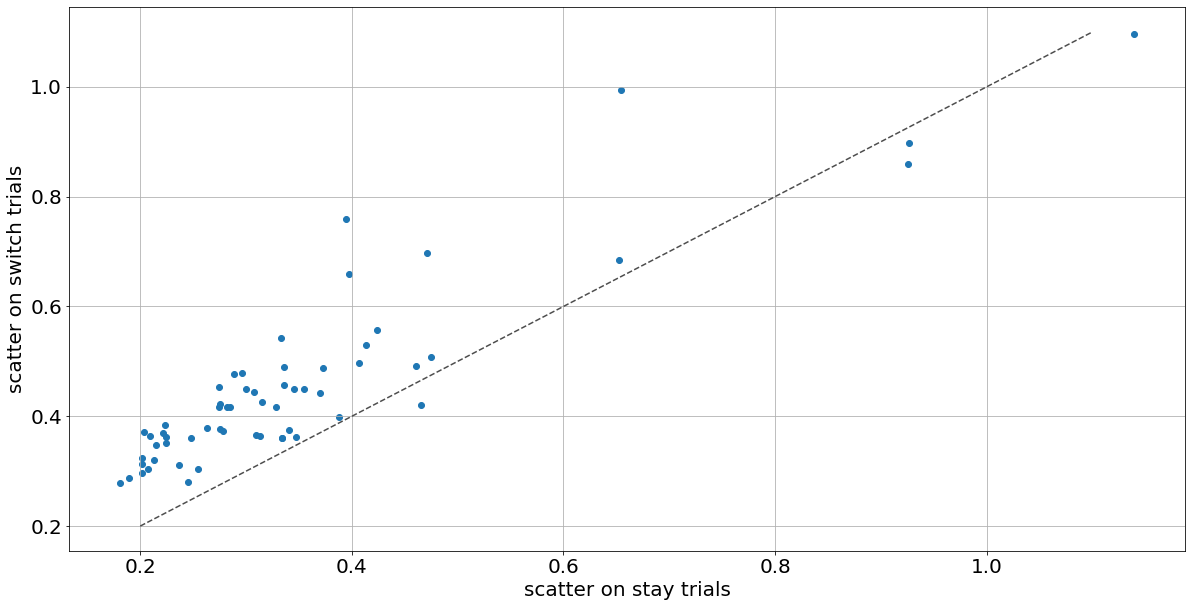

In [52]:
mean_switch_scatter = [np.mean(scatter_index[id_,:][is_switch[id_, :] == 1]) for id_ in range(np.shape(scatter_index)[0])]
mean_stay_scatter = [np.mean(scatter_index[id_,:][is_switch[id_, :] == 0]) for id_ in range(np.shape(scatter_index)[0])]

plt.scatter(mean_stay_scatter, mean_switch_scatter)
plt.xlabel("scatter on stay trials")
plt.ylabel("scatter on switch trials")
plt.plot([0.2, 1.1], [0.2, 1.1], ls="--", c=".3")

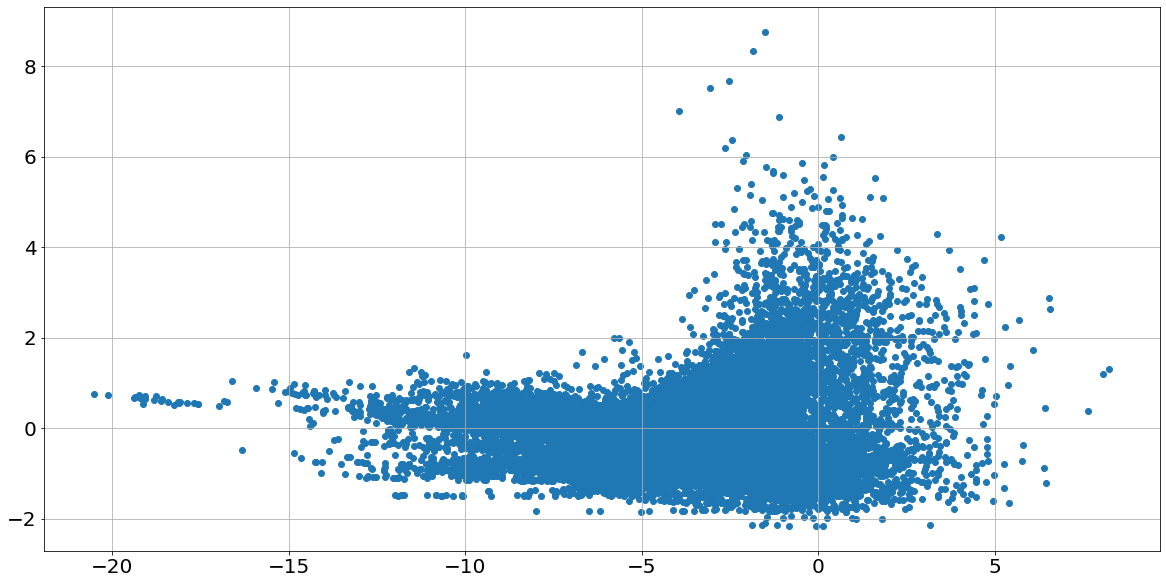

In [53]:
z_scatter_index = zscore(scatter_index, axis = 1)
z_switch_axis = zscore(switch_axis, axis = 1)

plt.scatter(switch_axis.flatten(), z_scatter_index.flatten())

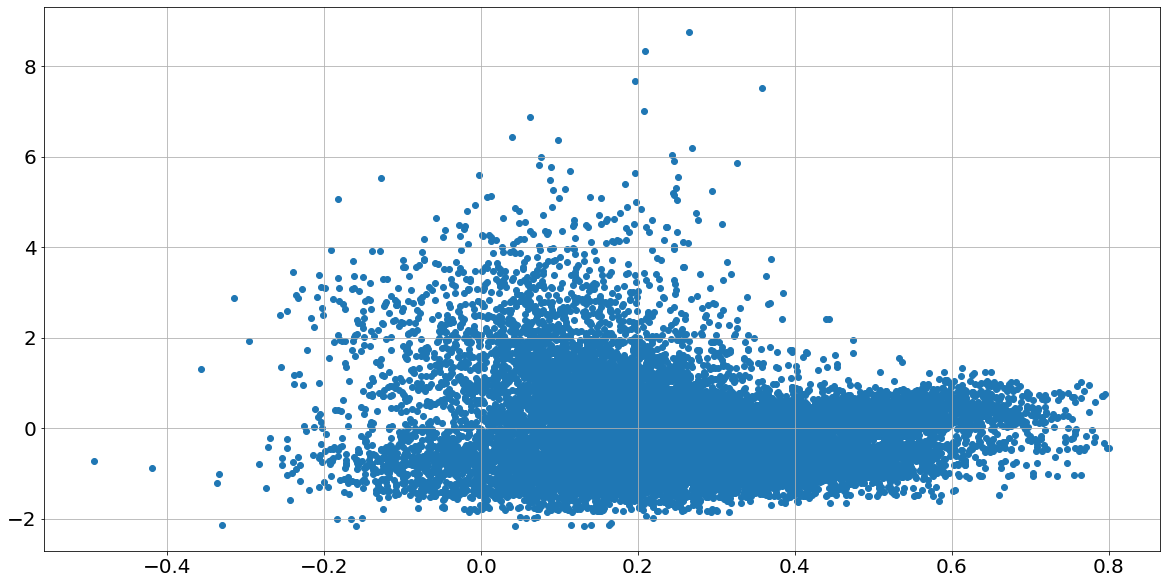

In [54]:
plt.scatter(value_axis.flatten(), z_scatter_index.flatten())

# log odds accumulation plot

In [55]:
WINDOW = 5

log_odds_switch = np.empty((N_IDS*N_WALKS,N_TRIALS, WINDOW + 1))
log_odds_switch[:,:,:] = np.nan

log_odds_mean_other = np.zeros((N_IDS*N_WALKS,N_TRIALS, WINDOW + 1))
log_odds_mean_other[:,:,:] = np.nan

for walk in range(1, N_WALKS+1):
    for id_ in range(N_IDS):

        # get data from RNN instance
        d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
        df = d.reset_index()
        
        # get log_odds of switches and mean other
        for t, switch in enumerate(df.is_switch.values):

            # choice set
            choice_set = [0,1,2,3]
            # current choice
            current_choice = df.choice.values[t]

            if switch == 1:

                # previous choice
                previous_choice = df.choice.values[t-1]

                # get log odds of switch
                log_odds_switch[(walk-1)*N_IDS+id_, t,WINDOW] = switch_choice_axis[(walk-1)*N_IDS+id_,t,current_choice]

                # log_odds of the switch up to t- WINDOW (build exception)
                for win in range(WINDOW):

                    # check if t- window is a positive integer:
                    if (t - WINDOW+win) > 0:
                        log_odds_switch[(walk-1)*N_IDS+id_, t, win] = switch_choice_axis[(walk-1)*N_IDS+id_,t - WINDOW+win, current_choice]

                # get choice set without current switch target
                choice_set.remove(current_choice)
                # get choice set without previous exploit choice
                choice_set.remove(previous_choice)

                # get log odds of one other action. Initiate with 0 to allow +=
                log_odds_mean_other[(walk-1)*N_IDS+id_, t, WINDOW] = 0 

                for a in choice_set:


                    log_odds_mean_other[(walk-1)*N_IDS+id_, t, WINDOW] += switch_choice_axis[(walk-1)*N_IDS+id_,t,a]

                    # log_odds of one other action up to t- WINDOW (build exception)
                    for win in range(WINDOW):

                        # check if t- window is a positive integer:
                        if (t - WINDOW+win) > 0:

                            log_odds_mean_other[(walk-1)*N_IDS+id_, t, win] = switch_choice_axis[(walk-1)*N_IDS+id_,t - WINDOW+win, a]
                            # to get mean log odds of other options divide by N_ACTIONS - 2 (switch target, previous choice) 
                            log_odds_mean_other[(walk-1)*N_IDS+id_,t, win] /= N_ACTIONS - 2  

                # to get mean log odds of other options divide by N_ACTIONS - 2 (switch target, previous choice)  
                log_odds_mean_other[(walk-1)*N_IDS+id_,t, WINDOW] /= N_ACTIONS - 2 



In [56]:
# calculate means
mean_lo_switch = np.nanmean(log_odds_switch, axis = 1)
mean_lo_mean_other = np.nanmean(log_odds_mean_other, axis = 1)


In [368]:
np.shape(mean_lo_mean_other)

(60, 6)

array([-4.18926883, -4.01530055, -3.74421303, -3.30375051, -2.93854948,
       -0.14493433])

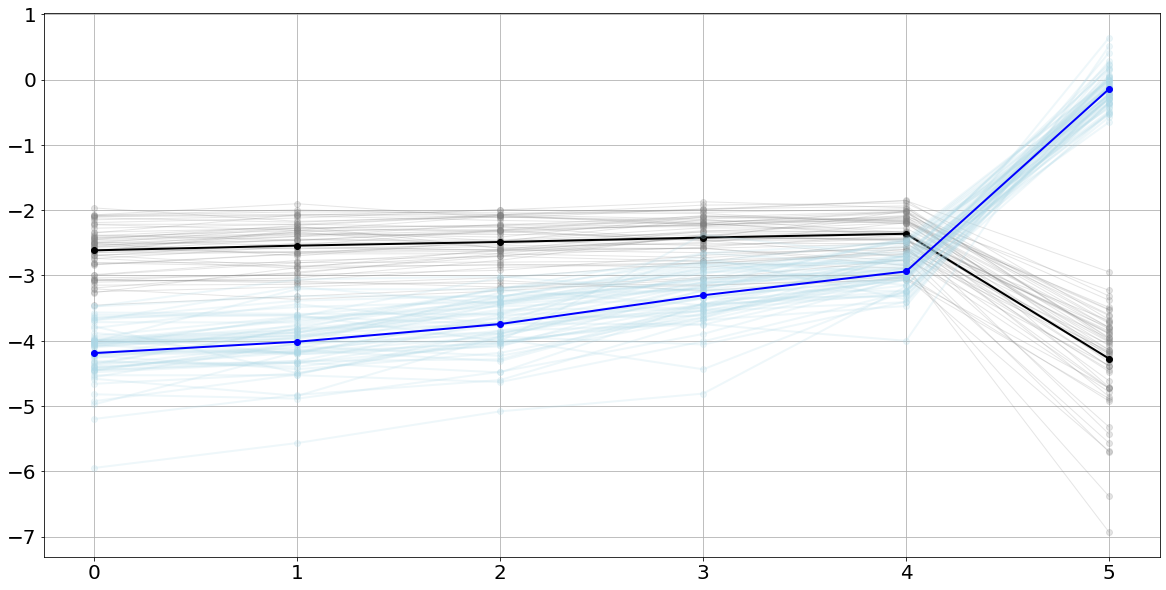

In [57]:
### plotting

for id_ in range(0,np.shape(mean_lo_switch)[0]):
    plt.plot(range(WINDOW+1), mean_lo_mean_other[id_, :], '-o', c = 'grey', linewidth=1, alpha = 0.2)

plt.plot(range(WINDOW+1), np.mean(mean_lo_mean_other, axis = 0), '-o', c = 'black', linewidth=2, alpha = 1)

for id_ in range(0,np.shape(mean_lo_switch)[0]):
    plt.plot(range(WINDOW+1), mean_lo_switch[id_, :], '-o', c = 'lightblue', linewidth=2, alpha = 0.2)

plt.plot(range(WINDOW+1), np.mean(mean_lo_switch, axis = 0), '-o', c = 'blue', linewidth=2, alpha = 1)
    
